In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import librosa
import librosa.display
import librosa.feature
import librosa.sequence
import io
from sklearn.manifold import Isomap, TSNE, MDS, LocallyLinearEmbedding
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from IPython.display import Audio

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [5]:
DIR = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class' 
DIR_AUDIO = DIR + '/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'
df_meta = pd.read_csv(f'{DIR}/meta.csv')
df_meta = pd.read_csv(io.StringIO(df_meta.to_csv(index=False)))
df_meta

,filename,scene_label,identifier
0,audio/airport-barcelona-0-0-a.wav,indoor,barcelona-0
1,audio/airport-barcelona-0-10-a.wav,indoor,barcelona-0
2,audio/airport-barcelona-0-11-a.wav,indoor,barcelona-0
3,audio/airport-barcelona-0-12-a.wav,indoor,barcelona-0
4,audio/airport-barcelona-0-13-a.wav,indoor,barcelona-0
...,...,...,...
14395,audio/tram-vienna-285-8635-a.wav,transportation,vienna-285
14396,audio/tram-vienna-285-8636-a.wav,transportation,vienna-285
14397,audio/tram-vienna-285-8637-a.wav,transportation,vienna-285
14398,audio/tram-vienna-285-8638-a.wav,transportation,vienna-285


In [66]:
files  = np.random.choice(df_meta['filename'],20)

In [67]:
files

array(['audio/park-lisbon-1104-43891-a.wav',
       'audio/metro_station-lisbon-1021-42294-a.wav',
       'audio/street_pedestrian-milan-1096-42850-a.wav',
       'audio/metro-stockholm-55-1612-a.wav',
       'audio/metro_station-helsinki-67-1989-a.wav',
       'audio/tram-london-189-5823-a.wav',
       'audio/shopping_mall-milan-1084-40858-a.wav',
       'audio/metro-stockholm-227-6847-a.wav',
       'audio/street_traffic-lisbon-1067-40096-a.wav',
       'audio/metro-paris-50-1520-a.wav',
       'audio/metro_station-lisbon-1221-45759-a.wav',
       'audio/bus-lyon-1186-45436-a.wav',
       'audio/metro_station-stockholm-84-2281-a.wav',
       'audio/bus-lyon-1124-41456-a.wav',
       'audio/metro_station-lyon-1077-42499-a.wav',
       'audio/tram-helsinki-184-5737-a.wav',
       'audio/airport-paris-7-308-a.wav',
       'audio/metro-barcelona-220-6630-a.wav',
       'audio/street_pedestrian-barcelona-260-7891-a.wav',
       'audio/bus-helsinki-211-6457-a.wav'], dtype=object)

In [8]:
BASEPATH = '/content/drive/My Drive/DCASE 2020 Challenge/TAU Urban Acoustic Scenes 2020 3Class/soundfiles/TAU-urban-acoustic-scenes-2020-3class-development/'

# Part 1: Feature Extraction

In [22]:
n_fft = 2048
hop_length = 512
win_length = 1024
def feature_extraction(y):
    t = np.array([i for i in range(len(y))])/(60*sr)
    plt.figure()
    plt.plot(t,y)
    plt.xlabel('Time (min)')
    plt.ylabel('Magnitude')
    plt.show()

    D = librosa.stft(y, n_fft=n_fft, hop_length=hop_length, win_length=win_length)
    S = np.abs(D)
    ssr = sr/hop_length # spectrogram sample rate
    print("ssr = ", ssr)
    return S

In [12]:
def process_features(feature):
  if len(feature.shape)==1:
    feature.shape=(feature.shape[0], 1)

  df = librosa.feature.delta(feature, axis=0)
  ddf = librosa.feature.delta(df, axis=0)

  uf = np.mean(feature, axis=0)
  sf = np.std(feature, axis=0)

  udf = np.mean(df, axis=0)
  sdf = np.std(df, axis=0)

  uddf = np.mean(ddf, axis=0)
  sddf = np.std(ddf, axis=0)

  #print(feature.shape, df.shape, ddf.shape, uf.shape, udf.shape, uddf.shape)

  return np.hstack( (uf, sf, udf, sdf, uddf, sddf) )

def texture_features_block(input_block):
  mfcc = librosa.feature.mfcc(S=input_block, sr=sr, n_mfcc=12).T
  p_mfcc = process_features(mfcc[:,1:])
  flatness = librosa.feature.spectral_flatness(S=input_block).T
  p_flat = process_features(flatness)
  centroid = librosa.feature.spectral_centroid(S=input_block).T
  p_cent = process_features(centroid)
  rolloff = librosa.feature.spectral_rolloff(S=input_block).T
  p_roll = process_features(rolloff)
  contrast = librosa.feature.spectral_contrast(S=input_block).T
  p_contrast = process_features(contrast)
  

  feat = np.hstack( (p_cent, p_flat, p_roll, p_mfcc, p_contrast))
  #print (feat.shape)
  return feat

In [13]:
def texture_features(S, texture_n=160, texture_hop=80): # in frames
  textures = []
  for i in range(0, S.shape[1]-texture_n, texture_hop):
    s_ = texture_features_block (S[:,i:i+texture_n])
    textures.append(s_)
  textures = np.array(textures)
  #t = np.array([i for i in range(textures.shape[0])])
  #t.shape=(t.shape[0],1)
  #textures = np.hstack( (t, textures) )
  return textures

# Part 2: Analysis

In [62]:
def analysis(X):
    # Normalization
    scaler = StandardScaler()
    X_ = scaler.fit_transform(X)

    def f_PCA():
        # PCA analysis
        projector = PCA(n_components=2)
        Xt_ = projector.fit_transform(X_)
        plt.figure()
        plt.scatter(Xt_[:,0], Xt_[:,1])
        plt.show()
    def f_MDS():
        # MDS analysis
        projector = MDS(n_components=2, metric=False)
        Xt_ = projector.fit_transform(X_)
        plt.figure()
        plt.scatter(Xt_[:,0], Xt_[:,1])
        plt.show()
    def f_LLE():
        # LLE analysis
        projector = LocallyLinearEmbedding(n_components=2)
        Xt_ = projector.fit_transform(X_)
        plt.figure()
        plt.scatter(Xt_[:,0], Xt_[:,1])
        plt.show()
    def f_TSNE():
        # t-SNE analysis
        projector = TSNE(n_components=2, perplexity=10)
        Xtsne_ = projector.fit_transform(X_)
        plt.figure()
        plt.scatter(Xtsne_[:,0], Xtsne_[:,1])
        plt.title('t-SNE analysis')
        plt.show()
        return Xtsne_
    def f_isomap():
        # Isomap Analysis
        projector = Isomap(n_components=2, n_neighbors=5)
        Xt_ = projector.fit_transform(X_)
        plt.figure()
        plt.scatter(Xt_[:,0], Xt_[:,1])
        plt.title('isomap analysis')
        plt.show()
        return Xt_

    '''f_PCA()
    f_MDS()
    f_LLE()
    '''
    return f_isomap(), f_TSNE()

# Part 3: Clustering

In [64]:
n_clusters= 7
def clustering(Xt_):
    kmeans = KMeans(n_clusters=n_clusters)
    clusters = kmeans.fit_transform(Xt_)
    #print(clusters)
    print(kmeans.labels_)

    plt.figure()
    plt.scatter(Xt_[:,0], Xt_[:,1], c=kmeans.labels_, cmap='jet', alpha=0.5)
    plt.title('Isomap clusters')
    plt.show()

    plt.figure()
    plt.plot(kmeans.labels_)
    plt.title('kmeans labels')
    plt.show()

    # t-SNE analysis
    plt.figure()
    plt.scatter(Xtsne_[:,0], Xtsne_[:,1], c=kmeans.labels_, alpha=0.5, cmap='jet' )
    plt.title('t-SNE clusters')
    plt.show()
    return clusters

# Part 4: Viterbi Filtering


In [69]:
def viterbi(Xt_, Xtsne, clusters):

    def transition_matrix(ndim, p_stay):
        T = np.ones ( (ndim, ndim)) * ((1-p_stay)/(ndim-1))
        T *= 1-np.eye(ndim)
        T += np.eye(ndim)*p_stay
        return T

    P = (1/(10**-6 + clusters)) / np.sum(1/(10**-6 + clusters), axis=1, keepdims=1)
    T = transition_matrix(n_clusters, 0.9)
    #print(T)
    states = librosa.sequence.viterbi(P.T, T)
    print(states)

    plt.figure()
    plt.scatter(Xt_[:,0], Xt_[:,1], c=states, alpha=0.5,  cmap='jet')
    plt.title('isomap state analysis')
    plt.show()

    plt.figure()
    plt.scatter(Xtsne_[:,0], Xtsne_[:,1], c=kmeans.labels_, alpha=0.5, cmap='jet' )
    plt.title('t-SNE state analysis')
    plt.show()

    plt.figure()
    plt.plot(states)
    plt.title('states')
    plt.show()

audio/park-lisbon-1104-43891-a.wav


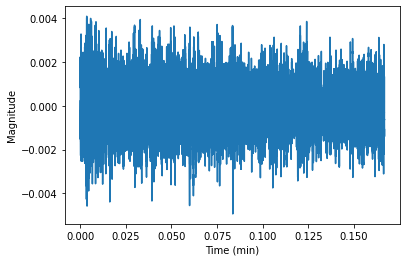

ssr =  43.06640625


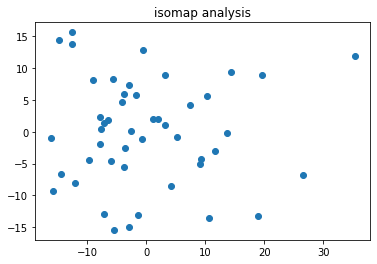

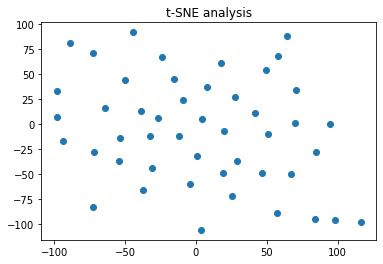

[4 2 5 4 4 2 4 1 4 4 0 1 4 1 5 0 1 2 1 1 0 5 0 3 6 0 3 3 4 1 2 1 0 3 5 4 1
 1 1 0 1 0 4 1 4 4 4]


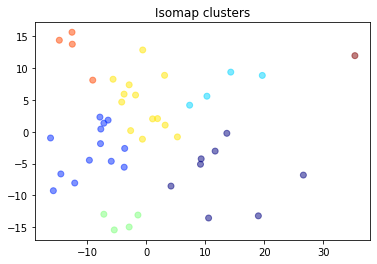

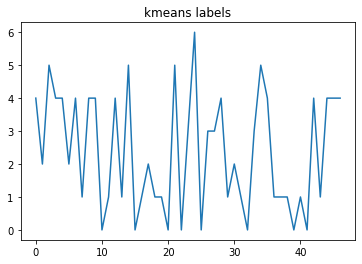

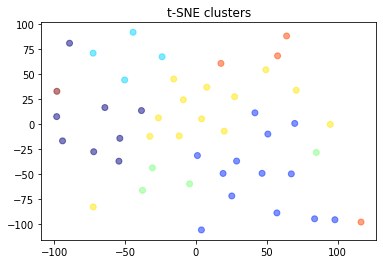

[4 4 4 4 4 4 4 4 4 4 4 4 4 1 1 1 1 1 1 1 1 1 1 1 6 4 4 4 4 4 4 4 4 4 4 4 4
 4 4 4 4 4 4 4 4 4 4]


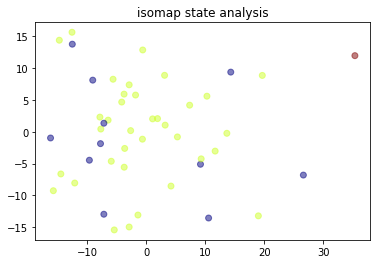

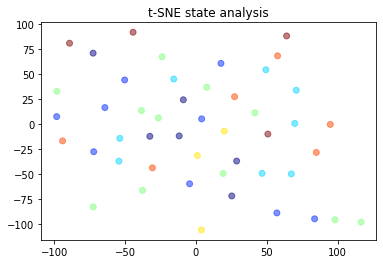

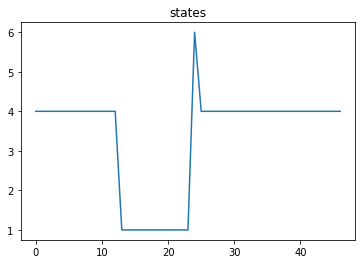

In [70]:
texture_n = 9
texture_hop = 9
for filename in files:
    print(filename)
    y, sr = librosa.load(BASEPATH + filename)
    S = feature_extraction(y)
    X = texture_features(S, texture_n=texture_n, texture_hop=texture_hop)
    Xt_ , Xtsne_ = analysis(X)
    clusters = clustering(Xt_)
    viterbi(Xt_, Xtsne_, clusters)
    break

In [60]:
changes = np.where(states[:-1] != states[1:])[0]
print(changes)
changes_n = np.hstack( (np.zeros(1), changes * texture_hop * hop_length) )
print(changes_n)
changes_t = changes_n / sr
print(changes_t)
print(states[changes])





[ 1 13 28 38]
[     0.   4608.  59904. 129024. 175104.]
[0.         0.20897959 2.71673469 5.85142857 7.94122449]
[3 6 2 0]


In [ ]:
seg_idx = 5

n_min = int(changes_n[seg_idx])
n_max = int(changes_n[seg_idx+1])
yi = y[n_min:n_max]
Audio(yi,rate=sr)

In [ ]:
print(states[changes[seg_idx]])
print(np.where(states[changes]==states[changes[seg_idx]]))

5
(array([3, 5]),)


URL relevante: https://www.music-ir.org/mirex/wiki/2020:Structural_Segmentation


In [ ]:
! pip install youtube-dl
import youtube_dl

     |████████████████████████████████| 1.8MB 4.6MB/s 


In [ ]:
import keras.layers
dir(keras.layers.normalization)

Using TensorFlow backend.


['BatchNormalization',
 'InputSpec',
 'K',
 'Layer',
 '__builtins__',
 '__cached__',
 '__doc__',
 '__file__',
 '__loader__',
 '__name__',
 '__package__',
 '__spec__',
 'absolute_import',
 'constraints',
 'division',
 'initializers',
 'interfaces',
 'print_function',
 'regularizers']

# Part 5: Texture Learning

In [ ]:
# Make list with spectrogram images
MelS = librosa.feature.melspectrogram(S=S)
print(texture_n, texture_hop, MelS.shape)

def make_images(S, texture_n=160, texture_hop=80): # in frames
  images = []
  for i in range(0, S.shape[1]-texture_n, texture_hop):
    s_ = S[:,i:i+texture_n].T
    #s_.shape = (s_.shape[0], s_.shape[1],1)
    images.append(s_)
  return images

Ximg = make_images(MelS, texture_n, texture_hop)
print(len(Ximg), Ximg[0].shape)

192 64 (128, 23767)
369 (192, 128)


In [ ]:
import keras.backend as K
import keras
import tensorflow as tf
from keras.models import Model
from keras.layers import Dense, Conv2D, Flatten, Dropout, AveragePooling2D, Input, LocallyConnected1D, Dropout, Concatenate, TimeDistributed, BatchNormalization, Lambda, Conv1D, Reshape
from keras.initializers import glorot_uniform as initializer
from keras.utils import to_categorical, plot_model, Sequence
print(keras.__version__)
print(tf.__version__)

2.3.1
2.2.0


In [ ]:
def make_pairs(Ximg, labels, batch_size, n_min):
  existing_labels = set(labels)

  # Remove elements with less than n examples
  L = [l for l in existing_labels]
  for l in L:
    this_n = len(np.where(labels==l)[0])
    if this_n < n_min:
      existing_labels.remove(l)
  
  curr_size = 0
  refs = []
  qrys = []
  eqs = []
  ls = [l for l in existing_labels]
  while curr_size < (batch_size/2):
    curr_label = ls[curr_size % len(ls)]
    idx_pos = np.where(labels==curr_label)[0]
    idx_neg = np.where(labels!=curr_label)[0]

    np.random.shuffle(idx_pos)
    np.random.shuffle(idx_neg)

    # Get Positive example
    refs.append(Ximg[idx_pos[0]])
    qrys.append(Ximg[idx_pos[1]])
    eqs.append(1)    

    refs.append(Ximg[idx_pos[2]])
    qrys.append(Ximg[idx_neg[0]])
    eqs.append(0)

    curr_size += 1

  return np.array(refs), np.array(qrys), to_categorical(eqs)


In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(Ximg, states, test_size=0.33, random_state=42, stratify=True)
refs, qrys, e = make_pairs(X_train, y_train, 10000, 5)
ref_, qry_, e_ = make_pairs(X_test, y_test, 1000, 5)

In [ ]:
print(refs.shape, qrys.shape, e.shape)

(10000, 192, 128) (10000, 192, 128) (10000, 2)


In [ ]:
# import math
# class PairGenerator(Sequence):
#   def __init__(self, imglist, labels, height, width, batch_size=32, shuffle=True):
#     self.imglist = imglist
#     for img in self.imglist:
#       img.shape = (img.shape[0], img.shape[1],1)
#     self.labels = labels
#     #print(labels)
#     self.batch_size = batch_size
#     self.shuffle=shuffle
#     self.on_epoch_end()

#   def __getitem__(self, idx):
#     x_idx = self.x_indexes[idx*self.batch_size:(idx+1)*self.batch_size]
#     x_els = []
#     for i in x_idx:
#       x_els.append (self.imglist[i])
#     lx = self.labels[x_idx]

#     y_idx = self.y_indexes[idx*self.batch_size:(idx+1)*self.batch_size]
#     y_els = []
#     for i in y_idx:
#       y_els.append (self.imglist[i])
#     ly = self.labels[y_idx]

#     label_out = lx==ly
#     return [np.array(x_els), np.array(y_els)], to_categorical(label_out)

#   def __len__(self):
#     return math.ceil( len(self.imglist) / self.batch_size)
  
#   def on_epoch_end(self):
#     self.
#     self.idx_ref, self.idx_qry, self.ly = make_pairs(self.labels, self.batch_size, 1)
#     for i in range(len(self.idx_ref)):



In [ ]:
# my_generator = PairGenerator(Ximg, np.array(states), Ximg[0].shape[0], Ximg[0].shape[1], batch_size=32)
#[Xref, Xqry], yref = generator[2]

In [ ]:
def normalize(x):
  mean = K.mean(x)
  std = K.mean( (x-mean)**2 )
  return (x-mean)/std

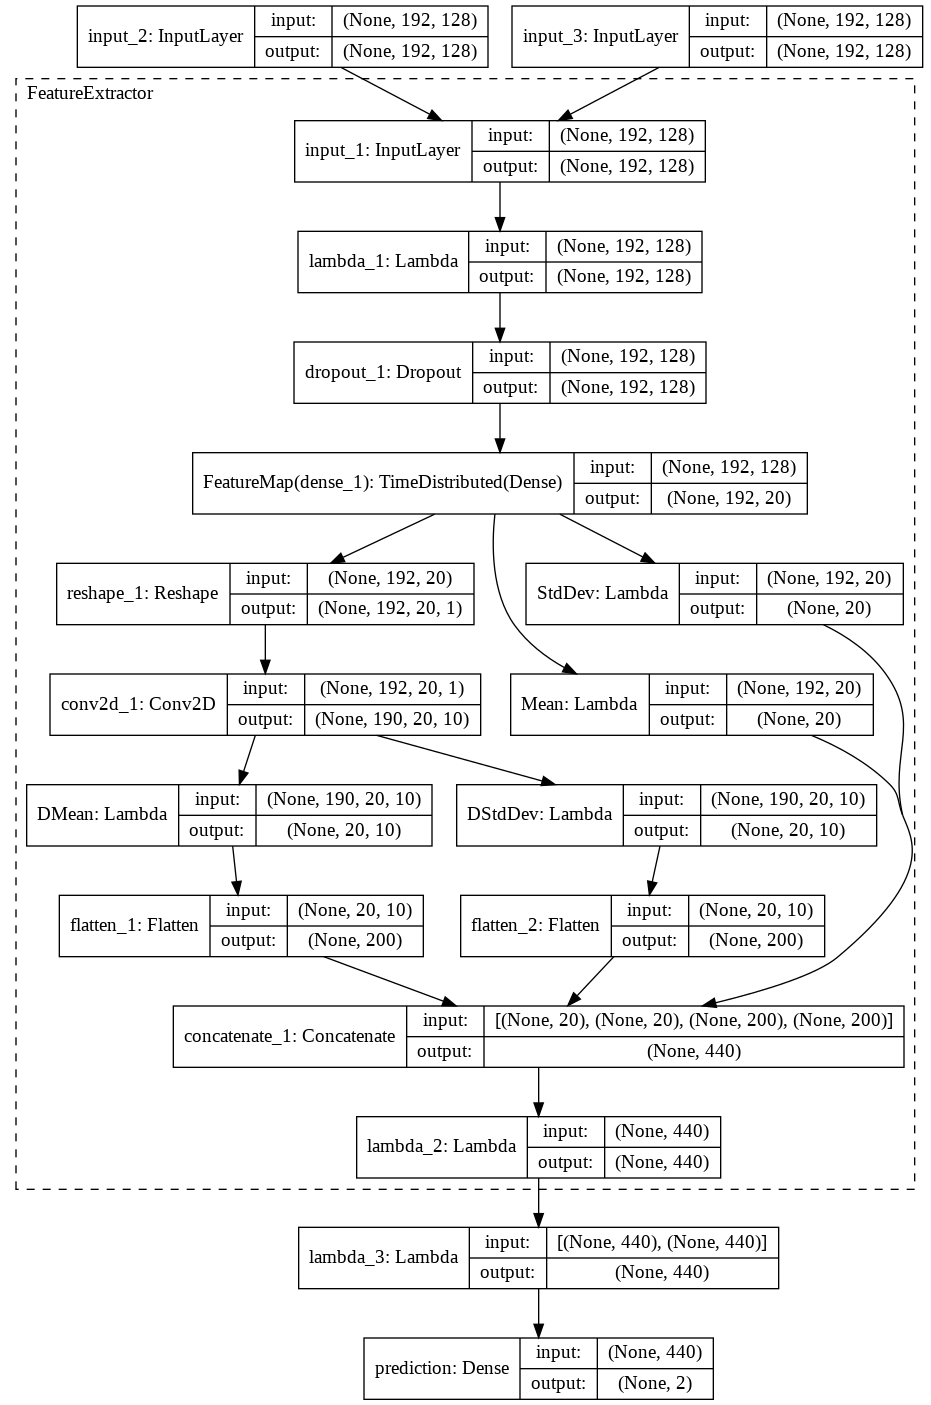

In [ ]:
timesteps_ = refs[0].shape[0]
nfreqs_ = refs[0].shape[1]

input_shape = (timesteps_,nfreqs_)


def create_shared_network(input_shape=input_shape, n_features=10):
  '''Shared network branch
  '''
  input_layer = Input(shape=input_shape)
  x = Lambda(normalize)(input_layer)
  x = Dropout(0.1)(x)
  x = TimeDistributed(Dense(n_features, activation='relu',  kernel_initializer=initializer()), name="FeatureMap")(x)
  #x = TimeDistributed(Dense(n_features, activation='relu',  kernel_initializer=initializer()))(x) 
  #x = TimeDistributed(Dense(n_features, activation='relu',  kernel_initializer=initializer()))(x)   
  mu = Lambda(lambda x: K.mean(x, axis=1), name="Mean")(x)
  std  = Lambda(lambda x: K.mean( (x-K.mean(x, axis=1, keepdims=True))**2, axis=1), name="StdDev")(x)
  
  rx = Reshape( (x.shape[1], x.shape[2], 1) )(x)
  dx = Conv2D(10, kernel_size=(3,1))(rx)
  dmu = Lambda(lambda x: K.mean(x, axis=1), name="DMean")(dx)
  fdmu = Flatten()(dmu)
  dstd  = Lambda(lambda x: K.mean( (x-K.mean(x, axis=1, keepdims=True))**2, axis=1), name="DStdDev")(dx)
  fdstd = Flatten()(dstd)

  x = Concatenate()([mu, std, fdmu, fdstd])#, mud, stdd, mudd, stddd])
  x = Lambda(normalize)(x)
  return Model(input_layer, x, name="FeatureExtractor")


shared_network = create_shared_network(input_shape, 20)

input_reference = Input(input_shape)
input_query = Input(input_shape)

processed_r = shared_network(input_reference)
processed_q = shared_network(input_query)

# Map features: should I concatenate?
#feature_map = Concatenate()([processed_r, processed_q])
#feature_map = Lambda(lambda x: K.sum( (x[0]-x[1])**2, axis=1, keepdims=True ) )([processed_r, processed_q])
feature_map = Lambda(lambda x:  (x[0]-x[1])**2 ) ([processed_r, processed_q])

#hidden = Dense(1, activation='relu',  kernel_initializer=initializer(), name="hidden")(feature_map)
output_layer = Dense(2, activation='softmax',  kernel_initializer=initializer(), name="prediction")(feature_map)

model=None
model=Model([input_reference, input_query], output_layer, name="classifier")
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

plot_model(model, show_shapes=True, expand_nested=True)
#print(model.summary())

In [ ]:
print(shared_network.summary())

Model: "FeatureExtractor"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 192, 128)     0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 192, 128)     0           input_1[0][0]                    
__________________________________________________________________________________________________
dropout_1 (Dropout)             (None, 192, 128)     0           lambda_1[0][0]                   
__________________________________________________________________________________________________
FeatureMap (TimeDistributed)    (None, 192, 20)      2580        dropout_1[0][0]                  
___________________________________________________________________________________

In [ ]:
model.fit([refs, qrys], e, epochs=10, batch_size=100, validation_data=([ref_, qry_], e_))

Train on 10000 samples, validate on 1000 samples
Epoch 1/10
10000/10000 [==============================] - 31s 3ms/step - loss: 0.8104 - accuracy: 0.6772 - val_loss: 0.5314 - val_accuracy: 0.7240
Epoch 2/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.4495 - accuracy: 0.8046 - val_loss: 0.4907 - val_accuracy: 0.8020
Epoch 3/10
10000/10000 [==============================] - 31s 3ms/step - loss: 0.3834 - accuracy: 0.8472 - val_loss: 0.4575 - val_accuracy: 0.8210
Epoch 4/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3460 - accuracy: 0.8681 - val_loss: 0.4329 - val_accuracy: 0.8420
Epoch 5/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.3178 - accuracy: 0.8795 - val_loss: 0.3990 - val_accuracy: 0.8580
Epoch 6/10
10000/10000 [==============================] - 30s 3ms/step - loss: 0.2888 - accuracy: 0.8948 - val_loss: 0.3851 - val_accuracy: 0.8610
Epoch 7/10
10000/10000 [==============================] - 30s 3ms/ste

In [ ]:
learned_textures = shared_network.predict(np.array(X_test))


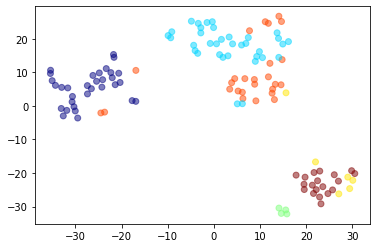

In [ ]:
# t-SNE analysis
projector = TSNE(n_components=2, perplexity=10)
Xt_ = projector.fit_transform(learned_textures)
plt.figure()
plt.scatter(Xt_[:,0], Xt_[:,1], c=y_test, alpha=0.5,  cmap='jet')
plt.show()

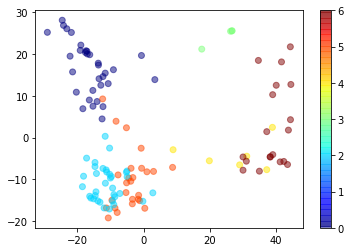

In [ ]:
# Isomap analysis
projector = Isomap(n_components=2,n_neighbors=5)
Xt_ = projector.fit_transform(learned_textures)
plt.figure()
plt.scatter(Xt_[:,0], Xt_[:,1], c=y_test, alpha=0.5,  cmap='jet')
plt.colorbar()
plt.show()